# Анализ лояльности пользователей Яндекс Афиши

Подключение к данным

Параметры подключения к базе данных вынесены в переменные окружения<br>
и не хранятся в репозитории по соображениям безопасности.<br>
Для запуска проекта необходимо создать файл `.env`<br>
по примеру и указать актуальные параметры подключения.

# Цели и задачи проекта

Цель проекта:<br>
Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.<br>

Задачи проекта:<br>
1. Общая подготовка данных:
* изучить полученные данные,
* выполнить объединение датафреймов
* произвести первичную обработку данных
* создать новые признаки, которые будут использоваться в дальнейшем анализе (в т.ч. конвертация тенге в рубли)

2. Построить профиль пользователя:
* сгруппировать данные по пользователю
* добавления бинарных признаков количества заказа

3. Провести исследовательский анализ данных (EDA):
* изучить полученные данные, после группировки данных
* исследовать распределение пользователей:
 * по типу их первого мероприятия
 * по типу устройства, с которого совершена первая покупка
 * по региону проведения мероприятия из первого заказа
 * по билетному оператору, продавшему билеты на первый заказ
* вычислить общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака  и выявить точки входа
* проанализировать повторные заказы пользователей:
 * для каждого сегмента вычислите долю пользователей, совершивших два и более заказа и визуализировать результат
* проверить имеющиеся гипотезы по повторным заказам
* исследовать поведение пользователей через показатели выручки и состава заказа:
 * оценить связь между средней выручкой сервиса с заказа и повторными заказами
 * сравнить распределение по средней выручке с заказа в двух группах пользователей
 * проанализировать влияние среднего количества билетов в заказе на вероятность повторной покупки
* исследовать временные характеристики первого заказа и их влияния на повторные покупки
* выполнить корреляционный анализ количества покупок и признаков пользоватлея

4. Сформулировать итоговые выводы и практические рекомендации для заказчика на основе результатов анализа

## Этапы выполнения проекта

### Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных 

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install phik
!pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine

In [4]:
load_dotenv()

connection_string = (
    f"postgresql://{os.getenv('DB_USER')}:"
    f"{os.getenv('DB_PASSWORD')}@"
    f"{os.getenv('DB_HOST')}:"
    f"{os.getenv('DB_PORT')}/"
    f"{os.getenv('DB_NAME')}"
)

engine = create_engine(connection_string)

In [5]:
# Из текста задания: 
# "Для выгрузки используйте запрос, который вы писали в третьем уроке проекта, «Выгрузка данных с помощью SQL»". 

query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    EXTRACT(DAY FROM (p.created_dt_msk - LAG(p.created_dt_msk) 
                      OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk))) AS days_since_prev,
    e.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
INNER  JOIN afisha.events AS e
    ON p.event_id = e.event_id
 LEFT JOIN afisha.city AS c
    ON c.city_id = e.city_id
 LEFT JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id
''' 

users_data = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [6]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [7]:
users_data.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


Данные объединены, датафрейм содержит 15 столбцов и 290611 строка.
Типы данных требуют корректировки.

---

###  Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Выполним нормализацию текстовых значений users_data

In [8]:
users_data['device_type_canonical'] = users_data['device_type_canonical'].str.lower().str.strip()
users_data['currency_code'] = users_data['currency_code'].str.lower().str.strip()
users_data['event_name'] = users_data['event_name'].str.lower().str.strip()
users_data['event_type_main'] = users_data['event_type_main'].str.lower().str.strip()
users_data['service_name'] = users_data['service_name'].str.lower().str.strip()
users_data['region_name'] = users_data['region_name'].str.lower().str.strip()
users_data['city_name'] = users_data['city_name'].str.lower().str.strip()

In [9]:
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [10]:
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [11]:
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [12]:
final_tickets_tenge_df.isna().sum()

data       0
nominal    0
curs       0
cdx        0
dtype: int64

Пропусков нет, нужно привести столбец data к соответствующему формату

In [13]:
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])
final_tickets_tenge_df['data'] = final_tickets_tenge_df['data'].dt.normalize()

In [14]:
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [15]:
# Проверим, действительно ли в final_tickets_tenge_df только тенге
final_tickets_tenge_df['cdx'].unique()

array(['kzt'], dtype=object)

In [16]:
# добавим в users_data данные final_tickets_tenge_df
users_data = users_data.merge(
    final_tickets_tenge_df[['data', 'curs']],
    left_on='order_dt',
    right_on='data',
    how='left'
)

In [17]:
# создадим дубль revenue, и выполним пересчет, если currency_code == kzt
# users_data['revenue_rub'] = users_data['revenue']

# mask_kzt = users_data['currency_code'] == 'kzt'
# users_data.loc[mask_kzt, 'revenue_rub'] = (
#     users_data.loc[mask_kzt, 'revenue'] *
#     users_data.loc[mask_kzt, 'curs'] / 100
# )

In [18]:
# Вариант создания currency_code, который короче и проще
users_data['revenue_rub'] = users_data['revenue'].where(
    users_data['currency_code'] == 'rub', 
    users_data['revenue'] * users_data['curs'] / 100
)

In [19]:
# уберем лишние столбцы и выведем, что у нас получилось
users_data.drop(columns=['data', 'curs'], inplace=True)

users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [20]:
result = users_data[users_data['currency_code'] == 'kzt']
#result
result.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,билеты без проблем,верхоречная область,серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,билеты без проблем,верхоречная область,серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,билеты без проблем,верхоречная область,серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,мой билет,верхоречная область,серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,мой билет,шанырский регион,широковка,1478.296591


для тенге выручка пересчиталась

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [21]:
users_data.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [22]:
users_data.isna().mean()*100

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          7.547202
event_id                 0.000000
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_name              0.000000
city_name                0.000000
revenue_rub              0.000000
dtype: float64

In [23]:
result = users_data[users_data[['days_since_prev']].isna().all(axis=1)]
#result
result.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,каменевский регион,глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,каменевский регион,глиногорск,289.45
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,североярская область,озёрск,8.49
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,край билетов,каменевский регион,глиногорск,917.83
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,лучшие билеты,поленовский край,дальнозолотск,47.78


days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено.
Пропуски объяснимы~~ но, заданием предлагается сократить размерность.
количество дней - целочисленное, но, надо заполнить пропуски. Для этого мы будет использовать "-1"~~

In [24]:
# т.к. предлагается изменить размерность, выполним это.
# order_id и event_id к object
# нужно посмотреть максимальные значения числовых значений, чтобы задать правильную размерность

users_data['order_id'] = users_data['order_id'].astype('object')
users_data['event_id'] = users_data['event_id'].astype('object')

numeric_max = users_data.select_dtypes(include=['number']).max()
print("Числовые столбцы:")
print(numeric_max)

Числовые столбцы:
revenue            81174.54
tickets_count         57.00
days_since_prev      148.00
revenue_rub        81174.54
dtype: float64


для числовых значений, разрядности имеют следующие диапазоны:<br>
* 8 (-128 - 127)
* 16 (-32768 - 32767)
* 32 (-2,147,483,648 - 2,147,483,647)

Исходя из максимумов, для числовых столбцов, можно задать следующие типы данных
revenue - float32 (суммы не целочисленные)
revenue_rub - float32 (суммы не целочисленные)
days_since_prev - int16 (количество дней - целочисленное)
tickets_count - int8 (количество билетов - целочисленное)

In [25]:
users_data['revenue'] = users_data['revenue'].astype('float32')
users_data['revenue_rub'] = users_data['revenue_rub'].astype('float32')
#users_data['days_since_prev'] = users_data['days_since_prev'].fillna(-1)
#users_data['days_since_prev'] = users_data['days_since_prev'].astype('int16')
users_data['is_first_order'] = users_data['days_since_prev'].isna().astype('int16')
users_data['tickets_count'] = users_data['tickets_count'].astype('int8')

In [26]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  object        
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  object        
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [27]:
users_data.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub,is_first_order
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,каменевский регион,глиногорск,1521.939941,1
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.450012,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,каменевский регион,глиногорск,289.450012,1
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.569946,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за билетом!,каменевский регион,глиногорск,1258.569946,0
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.490000,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,североярская область,озёрск,8.490000,1
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.410034,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты без проблем,озернинский край,родниковецк,1390.410034,0


Данные приведены к корректному типу.<br>

Проверим датафрейм на наличие отрицательных значений выручки

In [28]:
users_data[users_data['revenue_rub'] < 0]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub,is_first_order
252,00eb3dc9baa1543,mobile,1594653,2024-06-29,2024-06-29 15:01:43,rub,-2.37,3,NaN,538650,ffe03bc6-0e0c-480d-b037-6a4b55540ab5,другое,билеты без проблем,берёзовская область,златопольск,-2.37,1
4522,02ea4583333f064,mobile,2360920,2024-09-03,2024-09-03 18:12:58,rub,-0.23,3,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,билеты без проблем,широковская область,лесореченск,-0.23,0
4549,02ea4583333f064,mobile,2361094,2024-09-04,2024-09-04 09:34:53,rub,-0.15,2,0.0,559772,592856bb-09a5-4d32-9534-0e02c6056e44,другое,билеты без проблем,широковская область,лесореченск,-0.15,0
8133,043f669c9f734b1,mobile,166809,2024-09-27,2024-09-27 10:56:35,rub,-0.62,1,1.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,лучшие билеты,золотоключевской край,луговинец,-0.62,0
8134,043f669c9f734b1,mobile,166780,2024-09-27,2024-09-27 10:00:09,rub,-1.86,3,0.0,567183,9f571dad-b18a-4095-ac76-9db60d8dd97a,другое,лучшие билеты,золотоключевской край,луговинец,-1.86,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288855,fe237d2cfd6e503,mobile,3700575,2024-10-12,2024-10-12 08:11:33,rub,-5.70,1,0.0,247058,a3214473-934e-44ad-a8da-82915f51583f,концерты,тебе билет!,речицкая область,радужанов,-5.70,0
288903,fe237d2cfd6e503,desktop,3523646,2024-10-15,2024-10-15 20:32:18,rub,-1.43,3,0.0,243963,80f5f95b-9a58-401d-b888-4261335ae290,другое,лучшие билеты,ягодиновская область,речинцево,-1.43,0
288904,fe237d2cfd6e503,desktop,3523617,2024-10-15,2024-10-15 20:13:13,rub,-0.96,2,0.0,243963,80f5f95b-9a58-401d-b888-4261335ae290,другое,лучшие билеты,ягодиновская область,речинцево,-0.96,0
289052,fe237d2cfd6e503,mobile,5445853,2024-10-21,2024-10-21 20:22:29,rub,-0.61,1,0.0,243393,1f30acba-8b62-41c3-aaea-a80bf58d0d26,другое,лучшие билеты,ягодиновская область,речинцево,-0.61,0


In [29]:
# Убираем отрицательные значения выручки
rows_before = len(users_data)
filtered_rows = (users_data['revenue_rub'] < 0).sum()

users_data = users_data[users_data['revenue_rub'] >= 0]

rows_after = len(users_data)

print(f'Удалено строк: {rows_before - rows_after}')
print(f'Доля удалённых: {(rows_before - rows_after) / rows_before:.2%}')

Удалено строк: 381
Доля удалённых: 0.13%


Проверим на дубликаты

In [30]:
users_data[users_data.duplicated()]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub,is_first_order


Дубликатов нет

Проверим на неявные дубликаты по столбцам user_id и order_id

In [31]:
users_data[users_data.duplicated(subset=['user_id', 'order_id'], keep=False)]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub,is_first_order


Дубликатов нет

Теперь, выполним распределениие численных данных, на наличие выбросов.<br>
По столбцу revenue выполнятся распределениие не будет, т.к. в нем смешаны данные по разным валютам

In [32]:
# Определяем столбцы для анализа
columns_to_check = ['tickets_count', 'days_since_prev', 'revenue_rub']

# Создаем DataFrame для хранения статистик
iqr_stats = pd.DataFrame(index=columns_to_check, 
                         columns=['Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound'])

# Вычисляем IQR и границы для каждого столбца
for col in columns_to_check:
    Q1 = users_data[col].quantile(0.25)
    Q3 = users_data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_stats.loc[col] = [Q1, Q3, IQR, lower_bound, upper_bound]

print("Статистики IQR для каждого столбца:")
print(iqr_stats)


Статистики IQR для каждого столбца:
                         Q1      Q3         IQR lower_bound  upper_bound
tickets_count           2.0     4.0         2.0        -1.0          7.0
days_since_prev         0.0     1.0         1.0        -1.5          2.5
revenue_rub      114.610001  802.25  687.639999 -916.849998  1833.709999


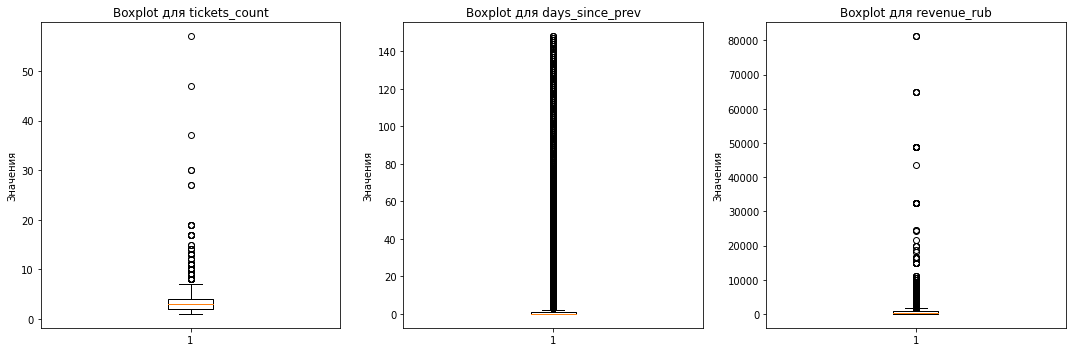

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(columns_to_check):
    axes[idx].boxplot(users_data[col].dropna())
    axes[idx].set_title(f'Boxplot для {col}')
    axes[idx].set_ylabel('Значения')

plt.tight_layout()
plt.show()

In [34]:
# Создаем словарь для хранения выбросов
outliers = {}

# Находим выбросы для каждого столбца
for col in columns_to_check:
    lower_bound = iqr_stats.loc[col, 'lower_bound']
    upper_bound = iqr_stats.loc[col, 'upper_bound']
    
    # Находим индексы выбросов
    col_outliers = users_data[
        (users_data[col] < lower_bound) | 
        (users_data[col] > upper_bound)
    ].index.tolist()
    
    outliers[col] = col_outliers
    
    print(f"\nВыбросы в столбце '{col}':")
    print(f"Количество выбросов: {len(col_outliers)}")
    print(f"Процент выбросов: {len(col_outliers)/len(users_data)*100:.2f}%")
    if len(col_outliers) > 0:
        print(f"Примеры значений выбросов: {users_data.loc[col_outliers[:5], col].tolist()}")


Выбросы в столбце 'tickets_count':
Количество выбросов: 126
Процент выбросов: 0.04%
Примеры значений выбросов: [10, 9, 9, 9, 9]

Выбросы в столбце 'days_since_prev':
Количество выбросов: 44163
Процент выбросов: 15.22%
Примеры значений выбросов: [75.0, 83.0, 19.0, 16.0, 74.0]

Выбросы в столбце 'revenue_rub':
Количество выбросов: 10453
Процент выбросов: 3.60%
Примеры значений выбросов: [2352.659912109375, 2121.550048828125, 2828.739990234375, 2815.60009765625, 2594.43994140625]


Количество наблюдений, когда было куплено более 7 билетов = 0,04%<br>
Почти 85% покупок, было совершено с интервалом в 2 дня<br>
96,4% покупок, было совершено до 1834,17 рубля

т.к. выбросы были обнаружены, выполняем пункт "Если обнаружите выбросы в поле revenue_rub, то отфильтруйте значения по 99 перцентилю"

In [35]:
# Вычисляем 99-й перцентиль
percentile_99 = users_data['revenue_rub'].quantile(0.99)

print(f"99-й перцентиль по revenue_rub: {percentile_99:.2f} руб.")

# Фильтруем данные - оставляем значения ≤ 991го перцентиля
filtered_data = users_data[users_data['revenue_rub'] <= percentile_99].copy()

print(f"Исходное количество строк: {len(users_data)}")
print(f"Отфильтрованное количество строк: {len(filtered_data)}")
print(f"Удалено строк: {len(users_data) - len(filtered_data)}")
print(f"Процент удаленных данных: {(1 - len(filtered_data)/len(users_data))*100:.2f}%")

99-й перцентиль по revenue_rub: 2628.42 руб.
Исходное количество строк: 290230
Отфильтрованное количество строк: 287405
Удалено строк: 2825
Процент удаленных данных: 0.97%


Проверим категориальные признаки:

In [36]:
for column in ['event_type_main', 'device_type_canonical', 'region_name', 'service_name']:
  print(f"\nColumn: {column}")
  print("Unique values:", filtered_data[column].unique())
  print("Missing values count:", filtered_data[column].isna().sum())
  print("Value counts:")
  print(filtered_data[column].value_counts(dropna=False), "\n")    


Column: event_type_main
Unique values: ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
Missing values count: 0
Value counts:
концерты    113466
театр        66728
другое       65291
спорт        21870
стендап      13272
выставки      4810
ёлки          1968
Name: event_type_main, dtype: int64 


Column: device_type_canonical
Unique values: ['mobile' 'desktop']
Missing values count: 0
Value counts:
mobile     230102
desktop     57303
Name: device_type_canonical, dtype: int64 


Column: region_name
Unique values: ['каменевский регион' 'североярская область' 'озернинский край'
 'лугоградская область' 'поленовский край' 'широковская область'
 'медовская область' 'златопольский округ' 'малиновоярский округ'
 'яблоневская область' 'ветренский регион' 'боровлянский край'
 'крутоводская область' 'ягодиновская область' 'серебряноярский округ'
 'лесодальний край' 'верхоречная область' 'горицветская область'
 'речиновская область' 'травиницкий округ' 'сосновская область'
 'сере

по столбцам region_name и service_name выявлены значения, с долей менее 1%, которые могут негативно влиять на устойчивость статистических оценок.
Нужно отфильтровать такие значения.

In [37]:
MIN_SHARE = 0.01

rows_total = len(filtered_data)

rare_regions = (
    filtered_data['region_name']
    .value_counts(normalize=True)
    .loc[lambda x: x < MIN_SHARE]
    .index
)

rare_services = (
    filtered_data['service_name']
    .value_counts(normalize=True)
    .loc[lambda x: x < MIN_SHARE]
    .index
)

In [38]:
rows_rare_region = filtered_data['region_name'].isin(rare_regions).sum()
rows_rare_service = filtered_data['service_name'].isin(rare_services).sum()
rows_rare_any = (
    filtered_data['region_name'].isin(rare_regions)
    | filtered_data['service_name'].isin(rare_services)
).sum()

print(f'Редкие region_name (<{MIN_SHARE:.0%}): {rows_rare_region} ({rows_rare_region/rows_total:.2%})')
print(f'Редкие service_name (<{MIN_SHARE:.0%}): {rows_rare_service} ({rows_rare_service/rows_total:.2%})')
print(f'Редкие по любому из двух: {rows_rare_any} ({rows_rare_any/rows_total:.2%})')


Редкие region_name (<1%): 45672 (15.89%)
Редкие service_name (<1%): 17886 (6.22%)
Редкие по любому из двух: 62204 (21.64%)


Для признаков region_name и service_name выяявлена большая доля редких категорий (менее 1%) - более 20%.<br>
Исключение или объединение этих категорий может привести к искажению результатов количественного анализа, поэтому дальнейшие расчёты выполнялись на исходных данных без изменения категориальных признаков.

In [39]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287405 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287405 non-null  object        
 1   device_type_canonical  287405 non-null  object        
 2   order_id               287405 non-null  object        
 3   order_dt               287405 non-null  datetime64[ns]
 4   order_ts               287405 non-null  datetime64[ns]
 5   currency_code          287405 non-null  object        
 6   revenue                287405 non-null  float32       
 7   tickets_count          287405 non-null  int8          
 8   days_since_prev        265705 non-null  float64       
 9   event_id               287405 non-null  object        
 10  event_name             287405 non-null  object        
 11  event_type_main        287405 non-null  object        
 12  service_name           287405 non-null  obje

Был добавлен столбец 'revenue_rub', который в себе содержит в себе данные о выручка от заказа, с учетом конвертации тенге в рубли.<br>
По текстовым столбцам была выполнена нормализация данных, путем приведения текста к нижнему регистру.<br>
Столбцы order_id и event_id преобразованы в тип object.<br>
Для числовых столбцов была изменена разрядность.<br>
Выполнена проверка на отрицательные значения выручки<br>
Всего удалено 381 строка с отрицательной выручкой<br>
Явных дубликатов не выявлено.<br>
Дубликатов по комбинации user_id и order_id не выявлено.<br>
~~В ходе выполнения преобразования 'days_since_prev', пропуски были заменены на "-1".<br>~~
В исходном датафрейме были обнаружены выбросы по числовым значениям, по этой причине, исходный датафрейм был отфильтрован по 99 перцентилю, по столбцу revenue_rub.<br>
Было удалено 2825 строк<br>
По категориальным признакам выявлены категории, доля которых менее 1%.<br>
Исключение или объединение этих категорий может привести к искажению результатов количественного анализа, поэтому дальнейшие расчёты выполнялись на исходных данных без изменения категориальных признаков.

---

### Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [40]:
# Выполняем рекомендацию (сортировка данных по времени совершения заказа пользователем)
filtered_data = filtered_data.sort_values(['user_id', 'order_ts'])

In [41]:
user_profile = (
    filtered_data
    .groupby('user_id')
    .agg(
        first_order_dt=('order_dt', 'first'),
        last_order_dt=('order_dt', 'last'),

        first_device=('device_type_canonical', 'first'),
        first_region=('region_name', 'first'),
        first_service=('service_name', 'first'),
        first_event_type=('event_type_main', 'first'),

        orders_count=('order_id', 'nunique'),

        avg_revenue_rub=('revenue_rub', 'mean'),
        avg_tickets_count=('tickets_count', 'mean'),

        avg_days_between_orders=('days_since_prev', lambda x: x[x != -1].mean())
    )
    .reset_index()
)


In [42]:
# добавляем бинарные признаки:

user_profile['is_two'] = (user_profile['orders_count'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_count'] >= 5).astype(int)


In [43]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,orders_count,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


avg_days_between_orders имеет пропуски, в случае, если это единственная покупка.<br>
is_two и is_five имеют 1, если совершил два или более заказа или пять и более, соответственно. Иначе - 0

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [44]:
# общее число пользователей в выборке;
user_profile['user_id'].nunique()

21838

In [45]:
# средняя выручка с одного заказа;
user_profile['avg_revenue_rub'].mean()

545.0328

In [46]:
# доля пользователей, совершивших 2 и более, 5 и более заказов;
share_two_plus = user_profile['is_two'].mean()
share_five_plus = user_profile['is_five'].mean()

print(share_two_plus*100)
print(share_five_plus*100)

61.70436853191684
28.995329242604633


In [47]:
# статистические показатели по общему числу заказов;
user_profile['orders_count'].describe()

count    21838.000000
mean        13.160775
std        121.577370
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: orders_count, dtype: float64

Исходя из того, что среднее количество заказов, в несколько раз больше медианы (13,17 и 2 заказа соответственно), можно сделать вывод, что распределение правосторонее.<br>
Максимальное количество заказов от одного пользователя - 10181, что явная аномалия. Возможно, это корпоративный аккаунт. 

In [48]:
# статистические показатели по среднему числу билетов в заказе
user_profile['avg_tickets_count'].describe()

count    21838.000000
mean         2.744062
std          0.913083
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets_count, dtype: float64

Среднее значение имеет незначительное отклонение от медианы.<br>
Максимальное значение - 11, что также может быть корпоративными покупками.

In [49]:
# статистические показатели по среднему количеству дней между покупками.
user_profile['avg_days_between_orders'].describe()

count    13504.000000
mean        15.864348
std         22.330357
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_days_between_orders, dtype: float64

Значения среднего времени между покупками могут отражать специфику бизнеса 

Для оценки влияния выбросов дополнительно была проведена фильтрация пользователей по 99-му перцентилю числа заказов.

In [50]:
limit = user_profile['orders_count'].quantile(0.99)

filtered_user_profile = user_profile[user_profile['orders_count'] <= limit]

removed = len(user_profile) - len(filtered_user_profile)
removed_share = removed / len(user_profile)

print(removed)
print(removed_share*100)

216
0.9891015660774796


Удалено 216 строк из 21854

In [51]:
# общее число пользователей по отфильтрованной выборке;
filtered_user_profile['user_id'].nunique()

21622

In [52]:
# средняя выручка с одного заказа;
filtered_user_profile['avg_revenue_rub'].mean()

545.34296

In [53]:
# доля пользователей, совершивших 2 и более, 5 и более заказов;
share_two_plus = filtered_user_profile['is_two'].mean()
share_five_plus = filtered_user_profile['is_five'].mean()

print(share_two_plus*100)
print(share_five_plus*100)

61.321801868467304
28.286004994912588


In [54]:
# статистические показатели по общему числу заказов, по отфильтрованной выборке;
filtered_user_profile['orders_count'].describe()

count    21622.000000
mean         6.496624
std         14.310784
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: orders_count, dtype: float64

После фильтрации, среднее значение уменьшилось с 13,17 до 6,5.<br>
Максимальное значение уменьшилось с 10181 до 152.<br>
Из этого можно сделать вывод, что удаленные данные носили аномальные значения

In [55]:
# статистические показатели по среднему числу билетов в заказе, по отфильтрованной выборке;
filtered_user_profile['avg_tickets_count'].describe()

count    21622.000000
mean         2.744256
std          0.917491
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_count, dtype: float64

In [56]:
# статистические показатели по среднему количеству дней между покупками, по отфильтрованной выборке;
filtered_user_profile['avg_days_between_orders'].describe()

count    13288.000000
mean        16.114766
std         22.423849
min          0.000000
25%          1.333333
50%          8.375000
75%         20.800000
max        148.000000
Name: avg_days_between_orders, dtype: float64

После фильтрации, статистические показатели менялись незначительно (за исключением orders_count)

---

### Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



**4.1.** Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [57]:
event_type_dist = (
    filtered_user_profile
    .groupby('first_event_type')
    .agg(users_count=('user_id', 'count'))
    .sort_values('users_count', ascending=False)
)

event_type_dist['share'] = (
    event_type_dist['users_count'] / event_type_dist['users_count'].sum()*100
)

event_type_dist


,users_count,share
first_event_type,,
концерты,9564,44.232726
другое,5401,24.979188
театр,4245,19.632781
стендап,1110,5.133660
спорт,794,3.672186
выставки,413,1.910092
ёлки,95,0.439367


По типу мероприятий, "Концерты" - точка входа.

In [58]:
device_dist = (
    filtered_user_profile
    .groupby('first_device')
    .agg(users_count=('user_id', 'count'))
)

device_dist['share'] = (
    device_dist['users_count'] / device_dist['users_count'].sum()*100
)

device_dist


,users_count,share
first_device,,
desktop,3716,17.186199
mobile,17906,82.813801


Четкой точкой входа являются мобильные устройства

In [59]:
region_dist = (
    filtered_user_profile
    .groupby('first_region')
    .agg(users_count=('user_id', 'count'))
    .sort_values('users_count', ascending=False)
)

region_dist['share'] = (
    region_dist['users_count'] / region_dist['users_count'].sum()*100
)

region_dist.head(10)


,users_count,share
first_region,,
каменевский регион,7086,32.772176
североярская область,3768,17.426695
широковская область,1223,5.656276
озернинский край,675,3.121820
малиновоярский округ,526,2.432707
шанырский регион,502,2.321709
травяная область,488,2.256961
светополянский округ,457,2.113588
речиновская область,440,2.034964


Значительная доля заказов приходится на Каменевский регион и Североярскую область 

In [60]:
service_dist = (
    filtered_user_profile
    .groupby('first_service')
    .agg(users_count=('user_id', 'count'))
    .sort_values('users_count', ascending=False)
)

service_dist['share'] = (
    service_dist['users_count'] / service_dist['users_count'].sum()*100
)

service_dist.head(10)


,users_count,share
first_service,,
билеты без проблем,5167,23.896957
мой билет,2970,13.736010
лови билет!,2812,13.005272
билеты в руки,2557,11.825918
облачко,2177,10.068449
весь в билетах,1286,5.947646
лучшие билеты,1182,5.466654
прачечная,583,2.696328
край билетов,454,2.099713


Наибольшее число пользователей совершили первый заказ через "Билеты без проблем".

Распределение пользователей по первому заказу является неравномерным.<br>
Заметна концентрация пользователей по типу устройства и типу первого мероприятия.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [61]:
base_return_rate = filtered_user_profile['is_two'].mean()
base_return_rate

0.6132180186846731

Средний процент совершивших два и более заказа, по очищенной выборке - 61,32% 

In [62]:
# функция для анализа сегментов
def return_rate_by_segment(df, segment_col, base_return_rate, top_n=None):
    result = (
        df
        .groupby(segment_col)
        .agg(
            users_count=('user_id', 'count'),
            return_rate=('is_two', 'mean')
        )
        .assign(
            is_above_base=lambda x: x['return_rate'] > base_return_rate
        )
        .sort_values('users_count', ascending=False)
    )
    
    if top_n:
        result = result.head(top_n)
    
    return result


In [63]:
event_return = return_rate_by_segment(
    filtered_user_profile, 
    'first_event_type', 
    base_return_rate
)
event_return

,users_count,return_rate,is_above_base
first_event_type,,,
концерты,9564,0.618151,True
другое,5401,0.595630,False
театр,4245,0.634393,True
стендап,1110,0.609009,False
спорт,794,0.557935,False
выставки,413,0.641646,True
ёлки,95,0.557895,False


<AxesSubplot:title={'center':'Доля пользователей с 2+ заказами по типу первого мероприятия'}, xlabel='first_event_type'>

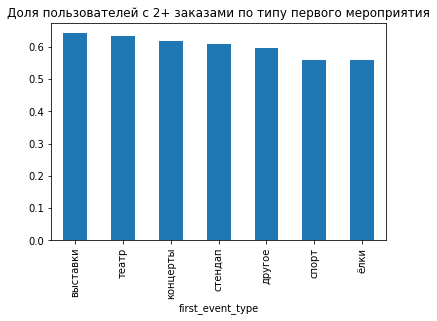

In [64]:
(
    event_return
    .sort_values('return_rate', ascending=False)['return_rate']
    .plot(
        kind='bar',
        title='Доля пользователей с 2+ заказами по типу первого мероприятия'
    )
)


Более высокая доля повторных заказов наблюдается у пользователей, совершивших первый заказ по типу первого мероприятия:<br>
* выставки
* театр
* концерты

In [65]:
device_return = return_rate_by_segment(
    filtered_user_profile, 
    'first_device', 
    base_return_rate
)
device_return

,users_count,return_rate,is_above_base
first_device,,,
mobile,17906,0.608008,False
desktop,3716,0.638321,True


<AxesSubplot:title={'center':'Доля пользователей с 2+ заказами по типу первого мероприятия'}, xlabel='first_device'>

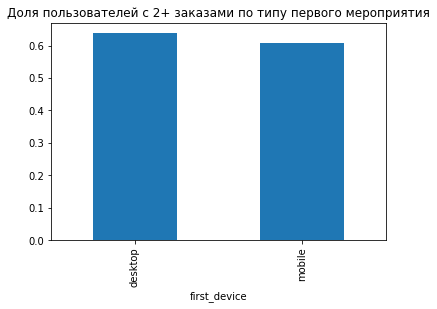

In [66]:
(
    device_return
    .sort_values('return_rate', ascending=False)['return_rate']
    .plot(
        kind='bar',
        title='Доля пользователей с 2+ заказами по типу первого мероприятия'
    )
)

С телефонов заказывают чаще, но доля повторных заказов выше с ПК

Анализ для регионов и билетным операторам будет выполняться по сегментам с наибольшим числом пользователей, так как для малочисленных сегментов значения долей могут быть нестабильными.

In [67]:
region_return = return_rate_by_segment(
    filtered_user_profile, 
    'first_region', 
    base_return_rate, 
    top_n=10
)
region_return

,users_count,return_rate,is_above_base
first_region,,,
каменевский регион,7086,0.623906,True
североярская область,3768,0.638270,True
широковская область,1223,0.644317,True
озернинский край,675,0.552593,False
малиновоярский округ,526,0.558935,False
шанырский регион,502,0.673307,True
травяная область,488,0.614754,True
светополянский округ,457,0.656455,True
речиновская область,440,0.634091,True


<AxesSubplot:title={'center':'Доля пользователей с 2+ заказами по региону первого заказа'}, xlabel='first_region'>

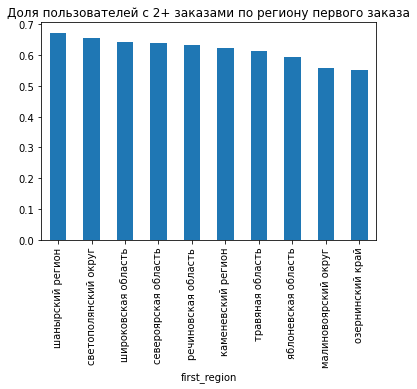

In [68]:
(
    region_return
    .sort_values('return_rate', ascending=False)['return_rate']
    .plot(
        kind='bar',
        title='Доля пользователей с 2+ заказами по региону первого заказа'
    )
)

In [69]:
service_return = return_rate_by_segment(
    filtered_user_profile, 
    'first_service', 
    base_return_rate, 
    top_n=10
)
service_return

,users_count,return_rate,is_above_base
first_service,,,
билеты без проблем,5167,0.603251,False
мой билет,2970,0.608754,False
лови билет!,2812,0.609531,False
билеты в руки,2557,0.627689,True
облачко,2177,0.612311,False
весь в билетах,1286,0.629082,True
лучшие билеты,1182,0.613367,True
прачечная,583,0.626072,True
край билетов,454,0.651982,True


<AxesSubplot:title={'center':'Доля пользователей с 2+ заказами по типу первого билетного оператора'}, xlabel='first_service'>

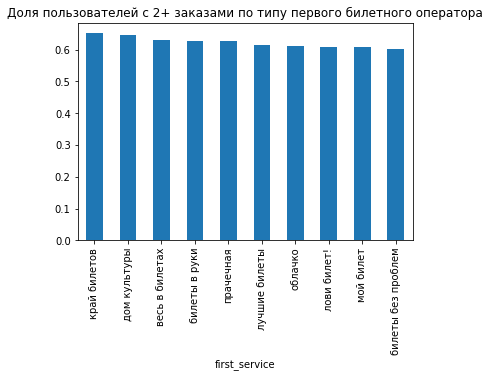

In [70]:
(
    service_return
    .sort_values('return_rate', ascending=False)['return_rate']
    .plot(
        kind='bar',
        title='Доля пользователей с 2+ заказами по типу первого билетного оператора'
    )
)

Возврат пользователей зависит от характеристик первого заказа. Для ряда сегментов, наблюдаются доли повторных покупок выше среднего по выборке, что позволяет рассматривать их как успешные точки входа.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [71]:
# Повторю, чтобы не искать по всему проекту, откуда взялся base_return_rate
base_return_rate = filtered_user_profile['is_two'].mean()
base_return_rate

0.6132180186846731

In [72]:
event_compare = (
    filtered_user_profile[filtered_user_profile['first_event_type'].isin(['спорт', 'концерты'])]
    .groupby('first_event_type')
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
    .assign(
            is_above_base=lambda x: x['return_rate'] > base_return_rate
    )
)

event_compare

,users_count,return_rate,is_above_base
first_event_type,,,
концерты,9564,0.618151,True
спорт,794,0.557935,False


Гипотеза 1 не подтверждается, т.к. на основе имеющихся данных, доля повторных заказов выше у тех пользователей, которые совершили первый заказ на концерт

In [73]:
region_stats = (
    filtered_user_profile
    .groupby('first_region')
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
    .assign(
            is_above_base=lambda x: x['return_rate'] > base_return_rate
    )
    .sort_values('users_count', ascending=False)
)

region_stats.head()


,users_count,return_rate,is_above_base
first_region,,,
каменевский регион,7086,0.623906,True
североярская область,3768,0.638270,True
широковская область,1223,0.644317,True
озернинский край,675,0.552593,False
малиновоярский округ,526,0.558935,False


Гипотеза 2 подтверждается, т.к. в более активных регионах, средняя доля пользователей, совершающих повторный заказ, выше, чем в менее активных регионах.

---

**4.2.** Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [74]:
one_order = filtered_user_profile[filtered_user_profile['orders_count'] == 1]['avg_revenue_rub']
returned = filtered_user_profile[filtered_user_profile['orders_count'] >= 2]['avg_revenue_rub']

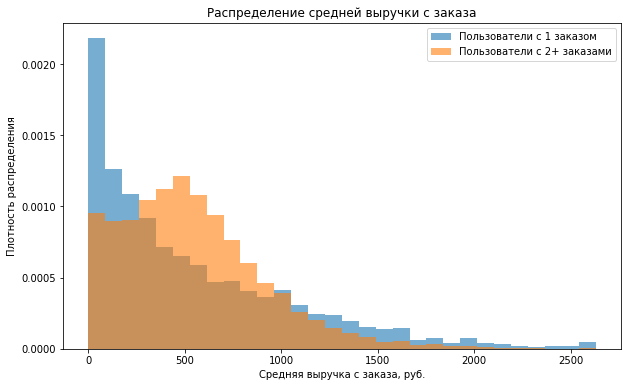

In [75]:
plt.figure(figsize=(10, 6))

plt.hist(
    one_order,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 1 заказом'
)

plt.hist(
    returned,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 2+ заказами'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа')
plt.legend()

plt.show()


Для пользователей с единственным заказом, выручка сконцентрирована в низких значениях (до 500 рублей, пиковое значение близко к нулю).<br>
Для пользователей, совершивших более одного заказа, пиковое значение около 500 рублей.<br>
Несмотря на значительное перекрытие распределений, можно отметить, что пользователи с более дорогими заказами в среднем чаще совершают повторные покупки, что может указывать на более высокую вовлечённость данной группы.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [76]:
orders_2_4 = filtered_user_profile[
    (filtered_user_profile['orders_count'] >= 2) & (filtered_user_profile['orders_count'] <= 4)
]['avg_revenue_rub']

orders_5_plus = filtered_user_profile[
    filtered_user_profile['orders_count'] >= 5
]['avg_revenue_rub']

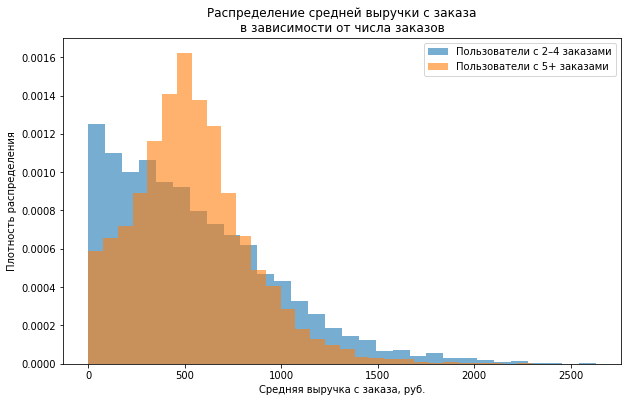

In [77]:
plt.figure(figsize=(10, 6))

plt.hist(
    orders_2_4,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 2–4 заказами'
)

plt.hist(
    orders_5_plus,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 5+ заказами'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа\nв зависимости от числа заказов')
plt.legend()

plt.show()


Для распределения средней выручки с заказа, для пользователей с 2-4 заказами, имеет пиковое значение около нуля. Однако, пик выражен не ярко, распределение имеет длинный "хвост".<br>
Для распределения средней выручки с заказа, для пользователей с 5 и более заказами, ярко выражен пик около 500 рублей. "Хвост" распределения короче, чем для пользователей с 2-4 заказами.<br>
Распределение средней выручки с заказа, для пользователей с 2-4 заказами, похоже на распредление выручки с заказа, для пользователей с один заказом.

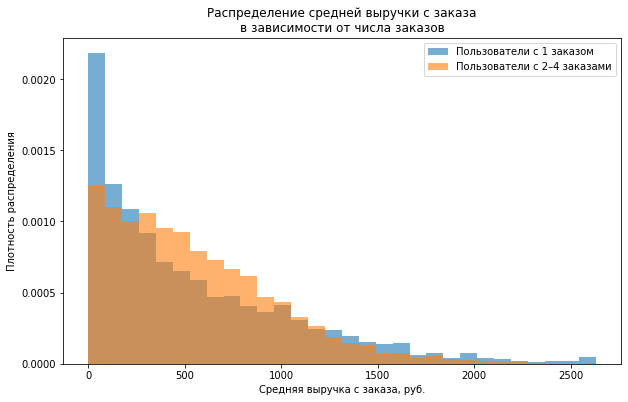

In [78]:
plt.figure(figsize=(10, 6))

plt.hist(
    one_order,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 1 заказом'
)

plt.hist(
    orders_2_4,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 2–4 заказами'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа\nв зависимости от числа заказов')
plt.legend()

plt.show()


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [79]:
# Повторим, чтобы не искать по проекту
filtered_user_profile['avg_tickets_count'].describe()

count    21622.000000
mean         2.744256
std          0.917491
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_count, dtype: float64

Среднее значение имеет незначительное отклонение от медианы.
Максимальное значение - 11, что также может быть корпоративными покупками.

In [80]:
# сделаем копию filtered_user_profile, чтобы в копию добавить категориальный признак
df = filtered_user_profile.copy()

def tickets_segment(x):
    if 1 <= x < 2:
        return '1–2 билета'
    elif 2 <= x < 3:
        return '2–3 билета'
    elif 3 <= x < 5:
        return '3–5 билетов'
    else:
        return '5+ билетов'

df['tickets_segment'] = df['avg_tickets_count'].apply(tickets_segment)


In [81]:
tickets_return = (
    df
    .groupby('tickets_segment')
    .agg(
        users=('user_id', 'count'),
        return_rate=('orders_count', lambda x: (x >= 2).mean())
    )
    .sort_values('users', ascending=False)
)

tickets_return


,users,return_rate
tickets_segment,,
2–3 билета,9487,0.735638
3–5 билетов,9064,0.542917
1–2 билета,2410,0.512448
5+ билетов,661,0.187595


Пользователи распределены по сегментам неравномерно.<br>
На сегменты 2-3 и 3-5 билетов приходится наибольшая доля пользователей.<br>
Наибольшая доля повторных покупок приходится на сегмент 2-3 билета(по сути - 2 билета).<br>
Вероятно, такие пользователи приобретают билеты для посещения мероприятий вдвоём, что способствует формированию устойчивой привычки использования сервиса.<br>
Наименьшая доля повторных покупок приходится на сегмент 5+ билетов.<br>
Можно предположить, что подобное количество билетов покупается для корпоративных мероприятий или для большой компании. В подобных случаях - повторные покупки совершаются редко.<br>
Не думаю, что описанные значения - аномальные

---

**4.3.** Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [82]:
# сделаем копию filtered_user_profile, чтобы в копию добавить день недели
df = filtered_user_profile.copy()

In [83]:
df['first_order_weekday'] = df['first_order_dt'].dt.dayofweek
df['first_order_weekday_name'] = df['first_order_dt'].dt.day_name()

In [84]:
weekday_stats = (
    df
    .groupby('first_order_weekday_name')
    .agg(
        users=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
)

In [85]:
# для того, чтобы шло по порядку дней недели
weekday_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday'
]

weekday_stats = weekday_stats.loc[weekday_order]
weekday_stats

,users,return_rate
first_order_weekday_name,,
Monday,2918,0.629883
Tuesday,3175,0.618898
Wednesday,3061,0.622672
Thursday,3112,0.594473
Friday,3256,0.597666
Saturday,3323,0.627746
Sunday,2777,0.600648


<AxesSubplot:title={'center':'Число пользователей по дню первой покупки'}, xlabel='first_order_weekday_name'>

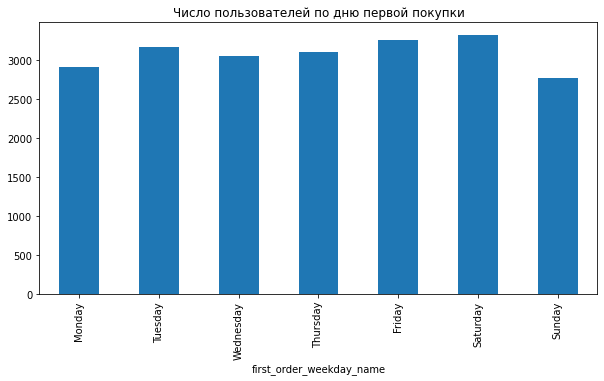

In [86]:
weekday_stats['users'].plot(
    kind='bar',
    figsize=(10, 5),
    title='Число пользователей по дню первой покупки'
)

Наибольшее количество первых покупок было совершено в пятницу и субботу, т.к. обычно, после этих дней следуют выходные.

Text(0, 0.5, 'Доля пользователей с 2+ заказами')

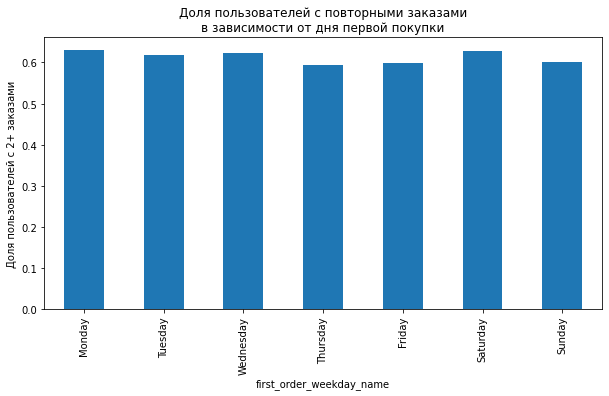

In [87]:
ax = weekday_stats['return_rate'].plot(
    kind='bar',
    figsize=(10, 5),
    title='Доля пользователей с повторными заказами\nв зависимости от дня первой покупки'
)

ax.set_ylabel('Доля пользователей с 2+ заказами')

Доли повторных заказов по дням недели отличаются незначительно и не демонстрируют выраженной зависимости от дня первой покупки.<br>
В целом, различия между днями недели могут быть обусловлены общими поведенческими паттернами пользователей и не обязательно указывают на причинно-следственную связь.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [88]:
# для задания нужно оставить строки, в котором количество заказов 2 и более
df_repeat = filtered_user_profile[filtered_user_profile['orders_count'] >= 2]

In [89]:
group_2_4 = df_repeat[
    (df_repeat['orders_count'] >= 2) &
    (df_repeat['orders_count'] <= 4)
]['avg_days_between_orders']

group_5_plus = df_repeat[
    df_repeat['orders_count'] >= 5
]['avg_days_between_orders']

In [90]:
group_2_4.describe(), group_5_plus.describe()

(count    7143.000000
 mean       21.348161
 std        28.514836
 min         0.000000
 25%         0.000000
 50%         9.000000
 75%        34.000000
 max       148.000000
 Name: avg_days_between_orders, dtype: float64,
 count    6116.000000
 mean        9.904038
 std         7.806116
 min         0.000000
 25%         3.884874
 50%         8.125000
 75%        14.102778
 max        37.500000
 Name: avg_days_between_orders, dtype: float64)

Для пользователей, совершивших 2-4 заказа, средний интервал между заказами - 21,35 дня, медианное значение - 9 дней.<br>
Для пользователей, совершивших 5 и более заказов, средний интервал между заказами - 9,9 дня, медианное значение - 8,13 дней.<br>
Из этого можно сделать вывод, что пользователи, совершившие 5 и более заказов, делают их чаще и с некоторой периодичностью.

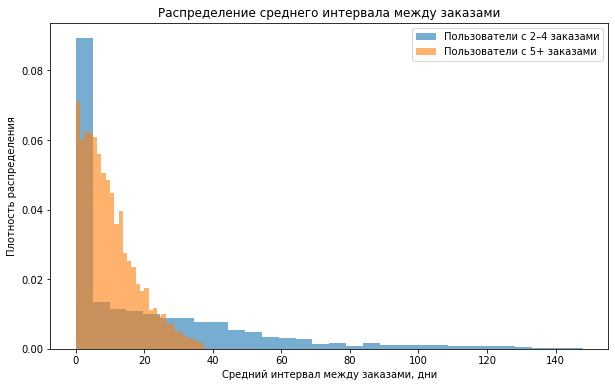

In [91]:
plt.figure(figsize=(10, 6))

plt.hist(
    group_2_4,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 2–4 заказами'
)

plt.hist(
    group_5_plus,
    bins=30,
    alpha=0.6,
    density=True,
    label='Пользователи с 5+ заказами'
)

plt.xlabel('Средний интервал между заказами, дни')
plt.ylabel('Плотность распределения')
plt.title('Распределение среднего интервала между заказами')
plt.legend()

plt.show()


Распределение для пользователей, совершивших 2-4 заказа, заметен длинный "хвост" вправо (до 148 дней).<br>
Распределение для пользователей, совершивших 5 и более заказов, смещено влево.<br>
Можно сделать вывод, что категория пользователей, совершивших 5 и более заказов, совершают заказы часто, с некоторой периодичностью, что может быть связано с большей вовлеченностью.

---

**4.4.** Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [92]:
corr_df = filtered_user_profile[[
    'orders_count',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'first_device',
    'first_event_type',
    'first_region',
    'first_service'
]]

In [93]:
#from phik import phik_matrix
phik_corr = corr_df.phik_matrix(
    interval_cols=[
        'orders_count',
        'avg_revenue_rub',
        'avg_tickets_count',
        'avg_days_between_orders'
    ]
)


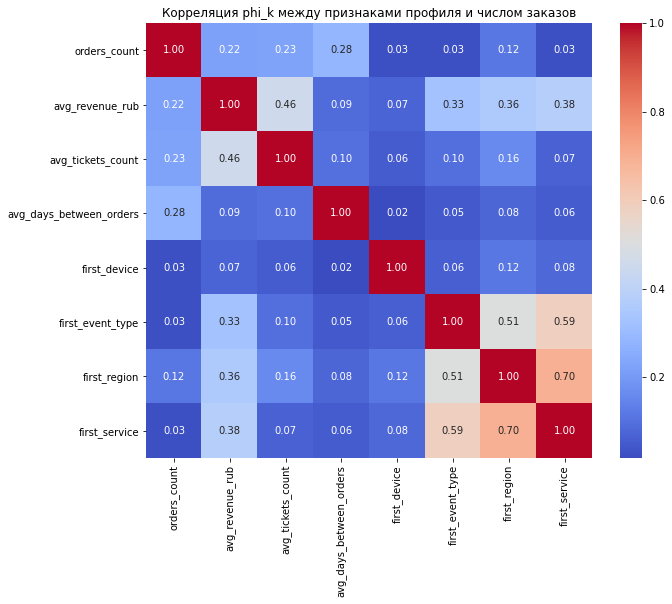

In [94]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    phik_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)

plt.title('Корреляция phi_k между признаками профиля и числом заказов')
plt.show()

Самая сильная связь, по всей выборке - между количеством заказов и количеством дней между заказами, но эта связь слабая.<br>
Корреляция может занижаться из-за большого количества пользователей, которые совершали только 1-2 заказа.<br> 
Поэтому, выделим сегменты по количеству заказов и повторим анализ.

In [95]:
def orders_segment(x):
    if x == 1:
        return '1 заказ'
    elif 2 <= x <= 4:
        return '2–4 заказа'
    else:
        return '5+ заказов'

segmented_df = filtered_user_profile.copy()
segmented_df['orders_segment'] = segmented_df['orders_count'].apply(orders_segment)

In [96]:
segment_corr = segmented_df[[
    'orders_segment',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'first_device',
    'first_event_type',
    'first_region',
    'first_service'
]].phik_matrix(
    interval_cols=[
        'avg_revenue_rub',
        'avg_tickets_count',
        'avg_days_between_orders'
    ]
)

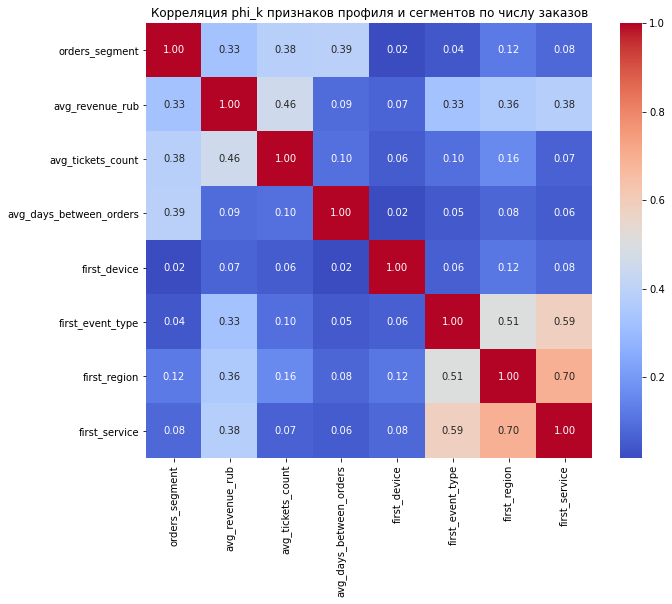

In [97]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    segment_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)

plt.title('Корреляция phi_k признаков профиля и сегментов по числу заказов')
plt.show()

После выделения сегментов по количеству заказов, можно отметить признаки с умеренной связью:<br>
* количество дней между заказами
* среднее количество билетов в заказе
* средняя стоимость заказа<br>

Прочие признаки - незначимы

### Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

В работе использовались данные заказов Яндекс Афиши, выгруженные из PostgreSQL и объединённые с таблицами событий и географии. Итоговый датасет содержал 15 признаков и 290 611 строк заказов.<br>
На этапе предобработки:
* Нормализованы текстовые поля (нижний регистр, удаление пробелов).
* Выручка приведена к одной валюте: для kzt выполнена конвертация по курсу (курс дан за 100 тенге) и создан столбец revenue_rub.
~~* Пропуски в days_since_prev (логичные для первой покупки) заполнены значением -1, далее столбец переведён в целочисленный тип.~~
* Оптимизированы типы данных (уменьшение разрядности числовых полей, order_id и event_id переведены в object).
* Удалено 381 строка с отрицательной выручкой.
* Для revenue_rub выполнена фильтрация выбросов по 99 перцентилю: удалено 2 825 строк (0,97%), после чего анализ строился на очищенной выборке заказов.
* Добавлены бинарные признаки is_two (2+ заказа) и is_five (5+ заказов). Для исключения влияния аномалий дополнительно отфильтрованы пользователи по 99 перцентилю числа заказов: удалено 216 пользователей (~0,99%).

В выборке: 
* ~~21 638~~ 21 622 пользователей (после фильтрации экстремальных по числу заказов).
* Средняя выручка с заказа: ~545 руб.
* Доля пользователей с повторными покупками:
 * 2+ заказа: ~~61,33~~ 61,32%
 * 5+ заказов: ~~28,30~~ 28,28%

Распределение заказов сильно правостороннее (медиана 2 заказа, 75% пользователей — до 5 заказов), что подтверждает наличие длинного "хвоста" более активных пользователей.

Средняя доля повторного заказа по выборке: ~~61,33~~ 61,32%.

Тип первого мероприятия:
* Выше среднего: выставки (~64%), театр (~63%), концерты (~61,8%).
* Ниже среднего: спорт (~55,8%), ёлки (~55,8%), «другое» (~59,6%).

Гипотеза о том, что спорт возвращает лучше концертов — не подтвердилась: у концертов возврат выше.

Устройство первого заказа:
* Первый заказ с desktop даёт выше вероятность возврата (~63,8%), чем с mobile (~60,8%), хотя по объёму «точка входа» — мобильные (≈83% пользователей).

Регион первого заказа:
* В крупных регионах (по числу пользователей) чаще наблюдается возврат выше среднего (например, Каменевский регион и Североярская область выше базы). Гипотеза о том, что в более активных регионах возврат выше — подтвердилась (при сравнении топ-регионов с менее активными).

Билетный оператор первого заказа:
* Есть операторы с возвратом выше среднего (в топ-10, например: «край билетов», «дом культуры», «весь в билетах», «билеты в руки» и др.), но различия незначительные

Связь выручки билетов с вероятностью повторных покупок:
* Пользователи с 1 заказом чаще концентрируются в более низких значениях выручки.
* У категории 2+ заказов пик распределения смещён в район ~500 руб.
* Для 5+ заказов распределение ещё более «собранное» вокруг ~500 руб., и "хвост" короче.

Среднее число билетов в заказе (сегменты):
* 1–2 билета: возврат ~51%
* 2–3 билета: возврат ~73,6% (лучший сегмент)
* 3–5 билетов: возврат ~54,3%
* 5+ билетов: возврат ~18,8% (самый слабый сегмент)

Ключевое наблюдение: самый «липкий» сценарий — покупка около 2 билетов (условно «вдвоём»). Сегмент 5+ билетов вероятно отражает разовые крупные покупки (группа/корпоратив), где повторяемость ниже.

День недели первой покупки:
* Существенного влияния на возврат не выявлено: доли колеблются в узком диапазоне (примерно 59–63%).
* По объёму первых покупок чаще встречаются пятница/суббота, что логично из-за выходных.

Корреляционный анализ (phi_k):
На полной шкале orders_count связи выглядели слабыми (эффект «забит» большим числом пользователей с 1–2 заказами). После сегментации по числу заказов (1 / 2–4 / 5+):
* Наиболее связаны с сегментом числа заказов:
 * средний интервал между покупками (чем меньше — тем выше сегмент),
 * среднее число билетов,
 * средняя выручка.
* Категориальные признаки первого заказа (регион/оператор/тип события/устройство) в корреляции проявились слабее и работают скорее как уточняющие факторы.

Основные рекомендации:
* 61% пользователей возвращаются, но ключевой барьер — превращение первой покупки в повторную, в первые 7–14 дней после первого заказа (не завязано на день недели, поэтому можно строить по времени от покупки).
* Пользователи со средним 2 билета дают максимальную долю повторных покупок (~74%). Можно усиливать данный сегмент следующим:
 * персональные предложения (подборки «куда сходить вдвоём», напоминания по жанрам, подписка/пакеты и т.д.)
 * стимулировать тех, кто купил 1 билет, в сторону 2 билетов (например, “приведи друга”, промо на второй билет).
* Развивать “успешные точки входа” по жанрам:
 * улучшить онбординг по категориям театр/выставка/концерты

### Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.** <br>
https://github.com/barbar375/module_2_afisha-analysis/tree/main